In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn 
import torch.optim as optim 
from torch.func import vmap, jacrev, functional_call
from torch.utils.data import Dataset

import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
# Boston Dataset :

# Prédiction du prix médian de maisons dans différentes banlieues de Boston, en fonction de plusieurs variables 
# socio-économiques, géographiques et environnementales.

In [3]:
data = pd.read_csv('Boston.csv').drop('Unnamed: 0', axis=1)
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
class BostonDataset(Dataset):
    def __init__(self, path="Boston.csv"):
        data = pd.read_csv(path).drop('Unnamed: 0', axis=1)
        self.features = data.drop('medv', axis=1)
        self.targets = data["medv"]
        self.features = StandardScaler().fit_transform(self.features)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return torch.Tensor(self.features[index]), torch.Tensor([self.targets[index]])

In [5]:
dataset = BostonDataset()

x_ntk = torch.stack([dataset[i][0] for i in range(100)])
print(x_ntk.shape)

# NTK shape : 100x100

torch.Size([100, 13])


In [6]:
class Network(nn.Module):
    def __init__(self, hidden_dim):
        super(Network, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(13, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.block(x)

In [7]:
model = Network(hidden_dim=10)
parameters = {k:v.detach() for k, v in model.named_parameters()}

In [8]:
# On a besoin d'une fonction qui prend en entrée les paramètres du réseau, et une observation 
# et qui retourne la prédiction du réseau, pour calculer le gradient par rapport aux paramètres.

def fnet_single(params, x):
    return functional_call(model, params, (x.unsqueeze(0), )).squeeze(0)

fnet_single(parameters, x_ntk[0]) == model(x_ntk[0].unsqueeze(0)).squeeze(0)

tensor([True])

In [9]:
# On va s'intéresser aux jacobians :

def f(x):
    return 2*torch.exp(x) + 6*x

def derivate(x):
    return 2*torch.exp(x) + 6

x = torch.tensor(2.0).unsqueeze(0)
jacrev(f, argnums=0)(x)==derivate(x)

tensor([[True]])

In [10]:
# Jacobian de fnet_single : donc du modèle par rapport aux paramètres :

jac = jacrev(fnet_single, argnums=0)(parameters, x_ntk)

In [11]:
# vmap : permet de vectoriser les calculs :

jac = vmap(jacrev(fnet_single), (None, 0))(parameters, x_ntk)

In [12]:
jac = jac.values()

In [13]:
jac = [j.flatten(1) for j in jac]

In [14]:
result = torch.stack([torch.einsum('Na, Mb -> NM', j, j) for j in jac])
print(result.shape) # dimension 4 parce que : weight0, bias0, weight2, bias2

torch.Size([4, 100, 100])


In [15]:
result = result.sum(0)
print(result.shape)

torch.Size([100, 100])


In [16]:
def get_ntk(fnet_single, params, x_ntk):
    jac = vmap(jacrev(fnet_single), (None, 0))(params, x_ntk)
    jac = jac.values()
    jac = [j.flatten(1) for j in jac]

    result = torch.stack([torch.einsum("Na, Mb -> NM", j, j) for j in jac])
    result = result.sum(0)

    return result

In [17]:
ntk = get_ntk(fnet_single, parameters, x_ntk)
print(ntk.shape)

torch.Size([100, 100])


In [18]:
def get_relative_norm(ntk_t, ntk_init):
    # Afin de voir l'évolution du NTK au cours de l'entraînement
    rel_norm = torch.linalg.norm(ntk_t - ntk_init)**2 / torch.linalg.norm(ntk_init)**2
    return rel_norm.item()

In [40]:
results_dict = {
    50:[[0] for _ in range(10)],
    100:[[0] for _ in range(10)],
    500:[[0] for _ in range(10)],
    1000:[[0] for _ in range(10)],
    5000:[[0] for _ in range(10)],
    10000:[[0] for _ in range(10)],
}

In [41]:
for dim in results_dict.keys():
    for iter in range(10):
        print(f'*** Working on model {dim} , iter {iter} ***')

        model = Network(dim)
        parameters = {k:v.detach() for k, v in model.named_parameters()}

        def fnet_single(params, x):
            return functional_call(model, params, (x.unsqueeze(0), )).squeeze(0)
        
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        ntk_init = get_ntk(fnet_single, parameters, x_ntk)

        for epoch in range(50):
            epoch_loss = 0
            for x, y in dataset:
                pred = model(x)
                loss = criterion(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss+=loss.item()

            print(f"for epoch {epoch} ; training loss : {epoch_loss}")

            parameters = {k:v.detach() for k, v in model.named_parameters()}
            ntk = get_ntk(fnet_single, parameters, x_ntk)
            rel_norm = get_relative_norm(ntk, ntk_init)
            results_dict[dim][iter].append(rel_norm)

*** Working on model 50 , iter 0 ***
for epoch 0 ; training loss : 294635.1727657318
for epoch 1 ; training loss : 293505.7222805023
for epoch 2 ; training loss : 292368.780708313
for epoch 3 ; training loss : 291219.75239372253
for epoch 4 ; training loss : 290058.0082397461
for epoch 5 ; training loss : 288884.39723587036
for epoch 6 ; training loss : 287697.97096061707
for epoch 7 ; training loss : 286496.8877429962
for epoch 8 ; training loss : 285280.2931537628
for epoch 9 ; training loss : 284047.646774292
for epoch 10 ; training loss : 282795.24979400635
for epoch 11 ; training loss : 281524.4274339676
for epoch 12 ; training loss : 280233.2247495651
for epoch 13 ; training loss : 278919.7860651016
for epoch 14 ; training loss : 277583.03108406067
for epoch 15 ; training loss : 276222.1737527847
for epoch 16 ; training loss : 274834.10724544525
for epoch 17 ; training loss : 273416.7699403763
for epoch 18 ; training loss : 271969.01593112946
for epoch 19 ; training loss : 270491

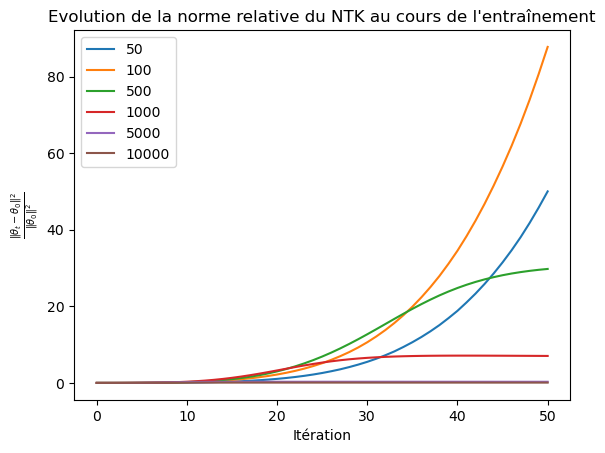

In [42]:
for dim in results_dict.keys():
    aa=np.mean(results_dict[dim], axis=0)
    plt.plot(aa, label=dim)
plt.xlabel('Itération')
plt.ylabel(r'$\frac{\|\theta_t - \theta_0\|^2}{\|\theta_0\|^2}$')
plt.title("Evolution de la norme relative du NTK au cours de l'entraînement")
plt.legend()
